# Read raiting CSV and drop the un-used item;

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; 

warnings.simplefilter('ignore')

rating = pd.read_csv('./ratings_drop.csv' , usecols=[ 'userId' , 'productId' , 'rating'] )
rating.dropna(subset=["userId"], inplace = True)
rating.dropna(subset=["rating"], inplace = True)
products = pd.read_csv('./products_join_categories.csv')
products = products.loc[:, ~products.columns.str.contains('^Unnamed')]
products.set_index( ['productId'] , inplace=True, drop=True )
products = products.rename({'name': 'product_name'}, axis='columns')
products.dropna(subset=["product_name"], inplace = True)
display(products.head())

,product_name,catIds,cat1,cat1_name,cat2,cat2_name,cat3,cat3_name
productId,,,,,,,,
0,CSSMs Biology: Control in Cells and in Organis...,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
1,Treasure Island,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿
2,Collins Primary Dictionaries – Collins Junior ...,"832,476,739",832,图书音像,476,其它图书,739.0,工具书
3,Partners in Crime,"832,476,923",832,图书音像,476,其它图书,923.0,进口图书
4,The Hobbit,"832,1101,1086",832,图书音像,1101,少儿/教育图书,1086.0,少儿


# Chunk model to read the big dataset and remove some column, finally generate the droped csv file

In [24]:
# chunksize = 500000
# col_names =  ['userId', 'productId', 'rating']
# final  = pd.DataFrame(columns = col_names)
# totalRows = 0
# for chunk in pd.read_csv('D:/step/ratings.csv', chunksize=chunksize):
#     del chunk['timestamp']
#     del chunk['comment']
#     del chunk['title']
#     final = pd.concat([final,chunk])
#     totalRows+=chunk.shape[0]
#     print("processing the first " + str(totalRows) + " rows" )
    
# print("Origin TotalRow is totalRows " + str(totalRows) )
# print( "After process , the totalRow is " + str(final.shape[0]) )
# final.head()
# final.to_csv('D:/step/ratings_drop.csv', encoding="utf_8_sig")

In [25]:
display(rating.head())

,userId,productId,rating
0,15905.0,452609,5.0
1,94522.0,452609,5.0
2,317087.0,452609,5.0
3,1329103.0,452609,5.0
4,502593.0,452609,5.0


# See how the data distributed

In [27]:
display(rating.describe())
print('No. of Unique Users    :', rating.userId.nunique())
print('No. of Unique Products :', rating.productId.nunique())
print('No. of Unique Ratings  :', rating.rating.nunique())

,userId,productId,rating
count,7.202839e+06,7.202839e+06,7.202839e+06
mean,3.368837e+05,2.651388e+05,4.277311e+00
std,3.619076e+05,1.525957e+05,1.060729e+00
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.653000e+04,1.331880e+05,4.000000e+00
50%,1.915990e+05,2.667810e+05,5.000000e+00
75%,5.283595e+05,3.965955e+05,5.000000e+00
max,1.424594e+06,5.256180e+05,5.000000e+00


No. of Unique Users    : 1424595
No. of Unique Products : 525619
No. of Unique Ratings  : 6


In [28]:
ratingViaUserCount = rating.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
ratingViaUserCount.columns = ['rating', 'Count']

# See the rating distribution

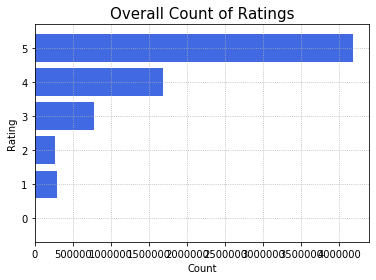

In [29]:
plt.barh(ratingViaUserCount.rating, ratingViaUserCount.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=10)
plt.ylabel('Rating', fontsize=10)
plt.grid(ls='dotted')
plt.show()

# Filter out some edge data, which the product has been rated less than 100 times and the users rate smaller than 50 times

In [30]:
userRatingCount = rating['userId'].value_counts();
ratingFiltered = rating[rating['userId'].isin(userRatingCount[userRatingCount >= 20 ].index)]
print(ratingFiltered.shape)
print(rating.shape)
productRatingCount = rating['productId'].value_counts();
ratingFiltered = ratingFiltered[ratingFiltered['userId'].isin(productRatingCount[productRatingCount >= 60 ].index)]
print(ratingFiltered.shape)

(2931315, 3)
(7202839, 3)
(107371, 3)


# Use pivot to transform the data to user-item-rating matrix

In [31]:
ratingFiltered.drop_duplicates(subset=['userId', 'productId'], keep='first' , inplace =True )
ratingFilteredPivot = ratingFiltered.pivot( index='userId' , columns='productId' , values="rating" ).fillna(0)

In [32]:
display(ratingFilteredPivot.sample(10))

productId,4,11,24,31,45,47,54,63,115,119,...,525455,525469,525475,525512,525516,525568,525584,525601,525607,525615
userId,,,,,,,,,,,,,,,,,,,,,
370231.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
231665.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7457.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102886.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104297.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150455.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169506.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24461.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Find users n number neighors for using cosine similarity
[Use sklearn Unsupervised Nearest Neighbors to find the Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)

In [35]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
#user based:
raitingFilteredMatrix = csr_matrix(ratingFilteredPivot.values)
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(raitingFilteredMatrix)
NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine', metric_params=None, n_jobs=1, n_neighbors=10, p=2, radius=1.0)

userId = 135065
queryIndex = ratingFilteredPivot.index.get_loc(userId)
distances, indices = model_knn.kneighbors(ratingFilteredPivot.iloc[queryIndex, :].values.reshape(1, -1), n_neighbors=11)

print('Recommendations for User({0}) :\n'.format( ratingFilteredPivot.iloc[queryIndex].name ))

for i in range(0, len(distances.flatten())):
      print('{0}: User({1}) , with distance of {2}:'.format(i, 
                                                            ratingFilteredPivot.iloc[indices.flatten()[i]].name,
                                                            distances.flatten()[i]))

[[1049 1057 1039  442 1050 1038  646 1047 1053  748 1041]]
[1049 1057 1039  442 1050 1038  646 1047 1053  748 1041]
Recommendations for User(135065.0) :

0: User(135065.0) , with distance of 0.0:
1: User(137584.0) , with distance of 0.7319033782010957:
2: User(133792.0) , with distance of 0.7635180344172997:
3: User(42844.0) , with distance of 0.7715173360213744:
4: User(135643.0) , with distance of 0.7821268029928199:
5: User(133754.0) , with distance of 0.7844422055590833:
6: User(70519.0) , with distance of 0.787998041940873:
7: User(134761.0) , with distance of 0.7903430326556163:
8: User(136943.0) , with distance of 0.7936191243140979:
9: User(86408.0) , with distance of 0.7965549904806056:
10: User(134010.0) , with distance of 0.8081098831973649:


# Base on those users, predict the user's interesting items by using the weighted formula:
![title](weighted_recom.png)

In [34]:
prediction=0
similarities = 1-distances.flatten()
sum_wt = np.sum(similarities)
wtd_sum = 0 
tempUserId = userId
notRatedItems = np.setdiff1d(ratingFilteredPivot.columns.to_numpy() , ratingFilteredPivot[ (ratingFilteredPivot.index == tempUserId) ].iloc[0].nonzero()[0] )
simArray = np.array([similarities]).T * ratingFilteredPivot.ix[indices.flatten()].filter(notRatedItems.tolist()).to_numpy()
sortedIndex = (simArray.sum(axis=0)/sum_wt).argsort()[::-1][:13]
for index , productId in enumerate(sortedIndex.tolist()):
    print('({0}). Prediction of User({1}): ProductId({2}) {3} ( {2} | {5} | {6} ):'.format(index,
                                                                                           tempUserId,
                                                                                           notRatedItems[productId],
                                                                                           products.loc[notRatedItems[productId]].product_name,
                                                                                           products.loc[notRatedItems[productId]].cat1_name,
                                                                                           products.loc[notRatedItems[productId]].cat2_name,
                                                                                           products.loc[notRatedItems[productId]].cat3_name ))


(0). Prediction of User(135065): ProductId(466683) Kingston 金士顿 DataTraveler 101 G2 64GB 绿色 优盘 ( 466683 | 存储设备 | U盘 ):
(1). Prediction of User(135065): ProductId(496884) Kingston 金士顿 DataTraveler 101 G2 8GB 优盘 ( 496884 | 存储设备 | U盘 ):
(2). Prediction of User(135065): ProductId(13316) Kingston 金士顿 DataTraveler 101 G2 32GB 优盘 ( 13316 | 存储设备 | U盘 ):
(3). Prediction of User(135065): ProductId(355070) Kingston 金士顿 DataTraveler 101 G2 4GB 优盘 ( 355070 | 存储设备 | U盘 ):
(4). Prediction of User(135065): ProductId(24064) Kingston 金士顿 DataTraveler 101 G2 16GB 优盘 ( 24064 | 存储设备 | U盘 ):
(5). Prediction of User(135065): ProductId(13329) Kingston 金士顿 8G microSDHC Class4 TF卡 ( 13329 | 存储设备 | 存储卡 ):
(6). Prediction of User(135065): ProductId(452966) 台电 X19+ MP3播放器(4GB 70小时超长待机 支持FM、无损音乐播放) ( 452966 | 数码影音 | mp3/mp4 ):
(7). Prediction of User(135065): ProductId(303295) OLAY玉兰油多效修护霜50g+OLAY玉兰油多效修护醒肤水150ml ( 303295 | 面部护理 | 面霜/乳液 ):
(8). Prediction of User(135065): ProductId(44692) ECOLA 宜客莱 CD-EL130 多功能电脑清洁套